## __Quickview Order__

This notebook builds on the example in the `quicksearch_download` notebook, using the same Iron Gate dam removal example to teach you how to examine the contents of your PlanetScope order of 8-band imagery, and index the assets you receive. You are welcome to input your own data and use the notebook as a template as well.

## Example workflow

#### Requirements

- Completed `quicksearch_download.ipynb` notebook with downloaded imagery.
- Python libraries: `rasterio`, `numpy`, `matplotlib`, `pathlib`
    - These can all be installed with the `requirements.txt` file provided.

#### Useful links
* [PlanetScope Specifications](https://developers.planet.com/docs/data/planetscope/)
* [Planet Orders API Documentation](https://docs.planet.com/develop/apis/orders/)
* [Pandas Documentation](https://pandas.pydata.org/docs/)

_______

#### Imports

In [32]:
import pathlib
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio

from datetime import datetime

#### Configuration

Before running any analysis on our PlanetScope Data, you will want to be familiar with what is included in an order and examine its contents. To do this we will use the `manifest.json` file provided with your order.

Following the example, your output folder from the order will look something like `notebooks/01_quickstart/example_workflow/order_output/<order_id>/PSScene`. You can copy your `order_id` from the quicksearch_order notebook to make this easy.

In [ ]:
# Local storage configuration
# If you changed the output directory in the download notebook, update it here too
order_id = 'your_order_id_here'  # replace with your actual order ID
cwd = pathlib.Path.cwd()

order_dir = cwd / 'example_workflow' / 'order_output' / order_id
imagery_dir = order_dir / 'PSScene'
print(imagery_dir)

____

#### Indexing Data with manifest.json

Manifest files are the last thing delivered in an order and include details about the items and assets included in the order. More information about the order manifest can be found [here](https://docs.planet.com/develop/apis/orders/delivery/#delivery-manifest). 

We will use the annotations included for each file to view a dataframe of the data we downloaded, then sort for only the paths to `ortho_analytic_8b_sr` assets. The manifest file is in a json format, and we will be turning it into a dataframe to make it easier to parse basic information in the notebook.

The information we are ultimately after by indexing the manifest is the date of the scene, as well as its relative filepath, which we will use to construct an absolute path in order the read the images for visualization.

In [33]:
manifest_path = order_dir / 'manifest.json'

with open(manifest_path) as f:
    manifest = json.load(f)

manifest_out = []
for item in manifest['files']:
    # we are not interested in metadata files for this
    if item['path'].endswith('metadata.json'):
        continue
    item_dict = item['annotations']
    item_dict['path'] = item['path']
    manifest_out.append(item_dict)

# Index and sort manifest dataframe by the item's date
manifest_df = pd.DataFrame(manifest_out)
manifest_df['date'] = manifest_df['planet/item_id'].apply(lambda item_id: datetime.strptime(item_id.split('_')[0], '%Y%m%d').date())
manifest_df.sort_values(by='date', inplace=True)
manifest_df.set_index('date', inplace=True)


imagery_df = manifest_df.loc[manifest_df['planet/asset_type'] == 'ortho_analytic_8b_sr']
imagery_paths = manifest_df.loc[manifest_df['planet/asset_type'] == 'ortho_analytic_8b_sr']['path']

In [34]:
# Preview of manifest dataframe
manifest_df.head()

,planet/asset_type,planet/bundle_type,planet/item_id,planet/item_type,path
date,,,,,
2024-05-08,ortho_analytic_8b_sr,analytic_8b_sr_udm2,20240508_181944_55_2455,PSScene,PSScene/20240508_181944_55_2455_3B_AnalyticMS_...
2024-05-08,ortho_udm2,analytic_8b_sr_udm2,20240508_181944_55_2455,PSScene,PSScene/20240508_181944_55_2455_3B_udm2_clip_r...
2024-05-08,ortho_analytic_8b_xml,analytic_8b_sr_udm2,20240508_181944_55_2455,PSScene,PSScene/20240508_181944_55_2455_3B_AnalyticMS_...
2024-05-31,ortho_analytic_8b_sr,analytic_8b_sr_udm2,20240531_190938_09_24d2,PSScene,PSScene/20240531_190938_09_24d2_3B_AnalyticMS_...
2024-05-31,ortho_analytic_8b_xml,analytic_8b_sr_udm2,20240531_190938_09_24d2,PSScene,PSScene/20240531_190938_09_24d2_3B_AnalyticMS_...


In [35]:
# Just the relative paths that we need:
imagery_paths

date
2024-05-08    PSScene/20240508_181944_55_2455_3B_AnalyticMS_...
2024-05-31    PSScene/20240531_190938_09_24d2_3B_AnalyticMS_...
2024-06-04    PSScene/20240604_191323_82_2473_3B_AnalyticMS_...
2024-06-28    PSScene/20240628_191500_95_2438_3B_AnalyticMS_...
2024-07-01    PSScene/20240701_182123_49_24c2_3B_AnalyticMS_...
2024-07-30    PSScene/20240730_182245_36_24c0_3B_AnalyticMS_...
2024-08-01    PSScene/20240801_181939_96_24a8_3B_AnalyticMS_...
2024-08-31    PSScene/20240831_191007_97_24fc_3B_AnalyticMS_...
2024-09-01    PSScene/20240901_190723_94_24f6_3B_AnalyticMS_...
2024-09-29    PSScene/20240929_191507_82_2514_3B_AnalyticMS_...
Name: path, dtype: object

In [36]:
# These variables are used below
dates = [date.isoformat() for date in imagery_paths.index.tolist()]
imagery_rel_paths = imagery_paths.tolist()

___

##### Load Imagery Data

Next we prepare to load the images and read them using rasterio. We set this up here for the following step of viewing them with matplotlib.

In [37]:
def load_image(filepath: pathlib.Path):
    """
    Load a TIFF file using rasterio.
    """
    with rasterio.open(filepath) as src:
        image_data = src.read()  # Read all bands
        metadata = src.meta.copy()

    return image_data, metadata

In [38]:
# Load all imagery into a list
print("Loading imagery... \n")

# Construct absolute paths from the manifest's paths and your working directory
abs_imagery_paths = [imagery_dir / pathlib.Path(rel_path).name for rel_path in imagery_rel_paths]
images = []

for date, path in zip(dates, abs_imagery_paths):
    image_data, metadata = load_image(path)
    filename = path.name

    images.append(image_data)
    print(f"{filename} on date {date}")
    print(f"Image shape: {image_data.shape} (bands, height, width)")
    print(f"Data type: {image_data.dtype} \n")

print(f"\nLoaded {len(images)} images")

Loading imagery... 

20240508_181944_55_2455_3B_AnalyticMS_SR_8b_clip_reproject.tif on date 2024-05-08
Image shape: (8, 646, 1129) (bands, height, width)
Data type: uint16 

20240531_190938_09_24d2_3B_AnalyticMS_SR_8b_clip_reproject.tif on date 2024-05-31
Image shape: (8, 646, 1129) (bands, height, width)
Data type: uint16 

20240604_191323_82_2473_3B_AnalyticMS_SR_8b_clip_reproject.tif on date 2024-06-04
Image shape: (8, 646, 1129) (bands, height, width)
Data type: uint16 

20240628_191500_95_2438_3B_AnalyticMS_SR_8b_clip_reproject.tif on date 2024-06-28
Image shape: (8, 646, 1129) (bands, height, width)
Data type: uint16 

20240701_182123_49_24c2_3B_AnalyticMS_SR_8b_clip_reproject.tif on date 2024-07-01
Image shape: (8, 646, 1129) (bands, height, width)
Data type: uint16 

20240730_182245_36_24c0_3B_AnalyticMS_SR_8b_clip_reproject.tif on date 2024-07-30
Image shape: (8, 646, 1129) (bands, height, width)
Data type: uint16 

20240801_181939_96_24a8_3B_AnalyticMS_SR_8b_clip_reproject.ti

____

## Part 2: Visualization

Next we will run some basic visualization of our imagery to see what we downloaded. We will be creating time series of RGB images with from our Order with some simple stretch to increase visibility. You may customize the width and height of the plots to suit your needs.

In [39]:
def create_rgb_img(image_data: np.ndarray, percentile_stretch: bool = True) -> np.ndarray:
    """
    Create a RGB composite from 8-band imagery.

    Uses Red (band 6), Green (band 4), Blue (band 2) to create a natural color image.

    Returns:
        RGB array with shape (height, width, 3) normalized to 0-1
    """
    # Extract bands (converting from 1-indexed to 0-indexed)
    red = image_data[5].astype(float)   # Band 6
    green = image_data[3].astype(float) # Band 4
    blue = image_data[1].astype(float)  # Band 2

    # Stack into RGB format (height, width, 3)
    rgb = np.dstack([red, green, blue])

    if percentile_stretch:
        # Apply percentile stretch to each band
        for i in range(3):
            band = rgb[:, :, i]
            p2, p98 = np.percentile(band[band > 0], [2, 98])
            rgb[:, :, i] = np.clip((band - p2) / (p98 - p2), 0, 1)
    else:
        # Simple normalization
        rgb = np.clip(rgb / 10000, 0, 1)  # Surface reflectance scaled to 0-10000

    return rgb

#### Create Image Plots

The following code cell creates a vertical time series plot of the RGB images. You may adjust the figure width and height variables to change the size of the output plot.  

In [40]:
# Width and Height of the output figure
figwidth = 5
figheight = 5

# Size of the titles for each subplot
title_size = 8

# figure title
title = 'Iron Gate Dam Removal Time Series\nRGB'

Created 10 images


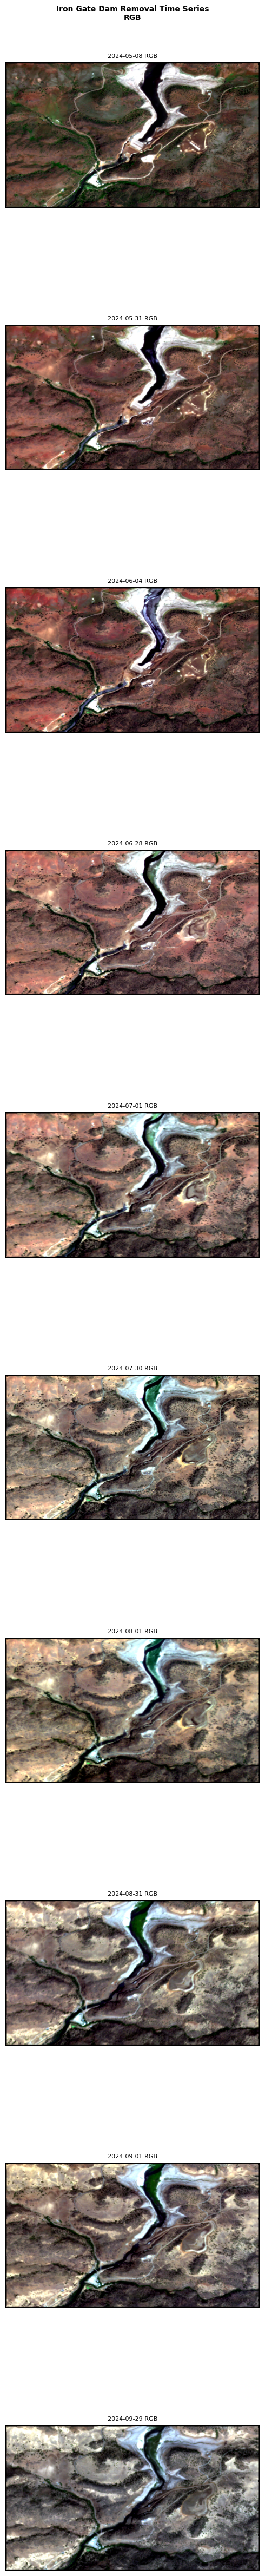

Time series visualization complete!
Dates shown: 2024-05-08 to 2024-09-29
Total images: 10


In [41]:
rgb_images = []

for i, (image, date) in enumerate(zip(images, dates)):
    tc_image = create_rgb_img(image)
    rgb_images.append(tc_image)

print(f"Created {len(rgb_images)} images")

# Create vertical time series plot
# Create figure with subplots: n_images rows x 1 column
n_images = len(rgb_images)
fig, axes = plt.subplots(
    n_images, 1,
    figsize=(figwidth, figheight * n_images)
)

# Handle case of single image
if n_images == 1:
    axes = [axes]

# Plot each date
for i, (img, date) in enumerate(zip(rgb_images, dates)):
    # RGB composite
    axes[i].imshow(img)
    axes[i].set_title(f'{date} RGB', fontsize=title_size)
    axes[i].axis('off')

# Add overall title
fig.suptitle(
    t=title,
    fontsize=10,
    fontweight='bold'
)

plt.tight_layout()
plt.show()

print("Time series visualization complete!")
print(f"Dates shown: {dates[0]} to {dates[-1]}")
print(f"Total images: {n_images}")

____

This quickview notebook barely scratches the surface of what is possible with PlanetScope data, but you should now have the tools to begin your analysis and be comfortable sorting through your orders.

### Additional Resources

- [PlanetScope Product Specifications](https://assets.planet.com/docs/Planet_PSScene_Imagery_Product_Spec_letter_screen.pdf)
- [Remote Sensing Indices](https://www.indexdatabase.de/)
- [Rasterio Documentation](https://rasterio.readthedocs.io/)
- [Matplotlib Gallery](https://matplotlib.org/stable/gallery/index.html)